# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, udf, isnull, min, max, sum as Fsum, avg, col, concat, desc, explode, lit, count 
from pyspark.sql.types import IntegerType, DateType
import datetime
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.classification import  RandomForestClassifier,  NaiveBayes, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import  StandardScaler, StopWordsRemover, CountVectorizer, IDF, VectorAssembler, Normalizer, PCA, RegexTokenizer, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import  ParamGridBuilder, CrossValidator
import re

In [2]:
# create a Spark session
build = SparkSession.builder
localsSpark = build.master("local")
createSpark = localsSpark.appName("Spark")
spark = createSpark.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load mini_sparkify_event_data (json file) and read it
sparkDf = spark.read.json('mini_sparkify_event_data.json')

### Checking dataset

#### Details of dataset

In [4]:
# general details
sparkDf.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [5]:
# top five rows
sparkDf.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
# last five rows
#sparkDf.tail(5)

In [7]:
# prints out the schema in the tree format
sparkDf.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Clean the dataset

In [8]:
# Delete rows containing missing values and rows that have an empty userid
userSet = ["userId", "sessionId"]
sparkDf = sparkDf.dropna(how = "any", subset = userSet)
id = sparkDf.userId
sparkDf = sparkDf.filter(id != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# the churn users
filteringData = sparkDf.filter(sparkDf.page=="Cancellation Confirmation")
selectingData = filteringData.select("userId")
withoutDuplicate = selectingData.dropDuplicates()
data = withoutDuplicate
churnData = [x["userId"] for x in data.collect()]
isUser = sparkDf.userId.isin(churnData)
itsChurn = sparkDf.withColumn("churn",isUser)

<AxesSubplot:xlabel='churn', ylabel='count'>

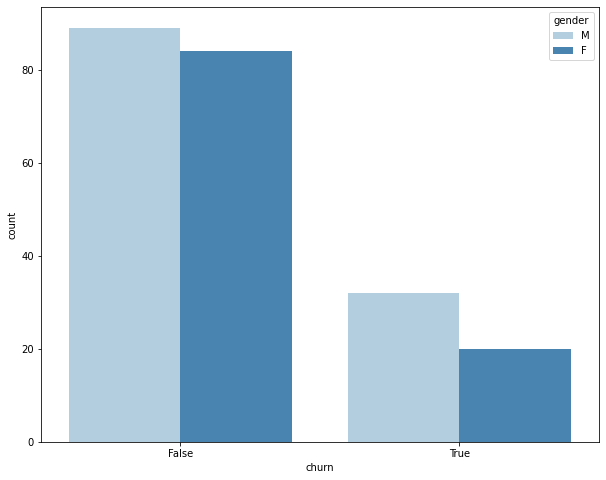

In [10]:
# the users who is Male and churn (M - True) and Male and not churn (M - False)
# also who is Famle and churn (F - True) and Famle and not churn (F - False)
dropDupDf = itsChurn.dropDuplicates(["userId", "gender"])
churnGenderDf = dropDupDf.groupby(["churn", "gender"])
nbChurnGender = churnGenderDf.count()
sChurnGenderDf = nbChurnGender.sort("churn")
churnGender = sChurnGenderDf.toPandas()
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(x='churn', y='count',ax=ax, hue='gender', data=churnGender, palette = "Blues")

<AxesSubplot:ylabel='page'>

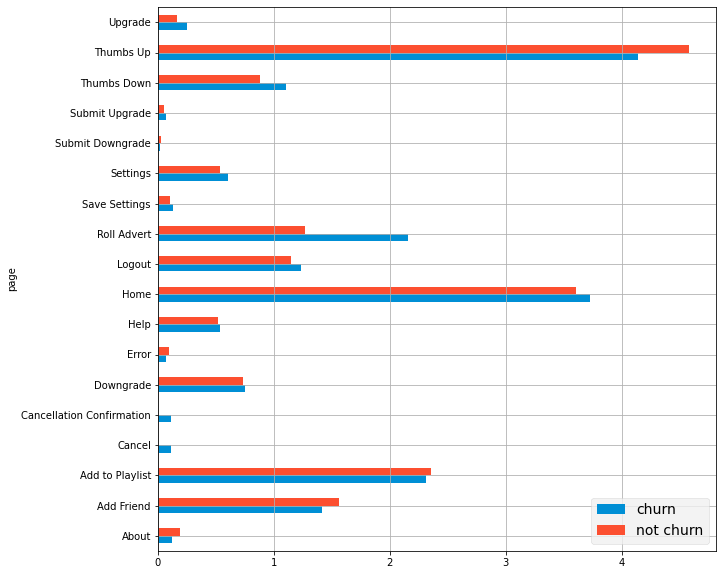

In [11]:
# the frequent of churn and not churn
check1 = itsChurn.churn==1
check0 = itsChurn.churn==0
filtData1 = itsChurn.filter(check1)
filtData2 = itsChurn.filter(check0)
cfiltData1 = filtData1.count()
cfiltData2 = filtData2.count()
div = cfiltData1/100
div2 = cfiltData2/100
notNextSong = itsChurn.page!="NextSong"
SongPage = filtData1.filter(notNextSong)
SongPageGroup = SongPage.groupby(["page"])
cSongPage = SongPageGroup.count()
page = cSongPage["count"]/ div 
SongPageCol = cSongPage.withColumn("churn",page)
cSongPage = SongPageCol.sort("page")
SongPageF = itsChurn.filter(check0)
SongPageNot = SongPageF.filter(notNextSong)
SongPageNotg = SongPageNot.groupby(["page"])
cSongPageNot = SongPageNotg.count()
page2 = cSongPageNot["count"]/div2
SongPageNChurn = cSongPageNot.withColumn("not churn", page2)
SongPageNChurnS = SongPageNChurn.sort("page")
joinDf = cSongPage.join(SongPageNChurnS, "page", "outer")
dropDupDf = joinDf.drop("count")
fillDf = dropDupDf.fillna(0)
dropDupDf = fillDf.toPandas()
dims = (10, 10)
fig, ax = plt.subplots(figsize=dims)
plt.style.use('fivethirtyeight') 
dropDupDf.plot("page", kind="barh", ax=ax)

<AxesSubplot:xlabel='level', ylabel='count'>

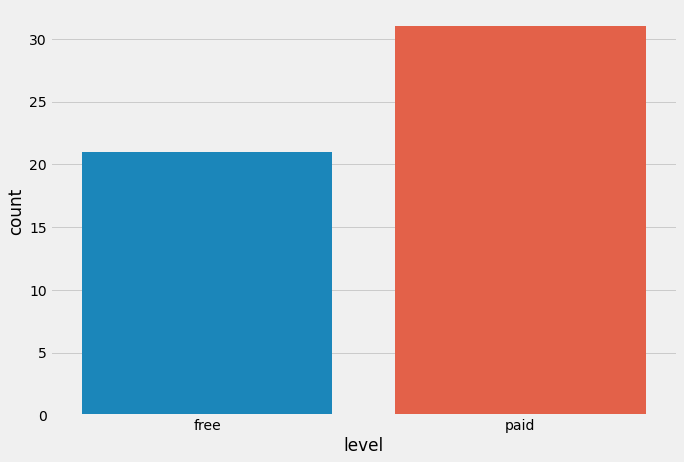

In [12]:
# the number of cancellation confirmation for each free and paid users
checkPage = itsChurn.page == "Cancellation Confirmation"
filtPageDf = itsChurn.filter(checkPage)
groPageDf = filtPageDf.groupby("level")
nbgroPageDf = groPageDf.count()
dropDupDf = nbgroPageDf.toPandas()
dims = (10, 7)
fig, ax = plt.subplots(figsize=dims)
plt.style.use('fivethirtyeight') 
sns.barplot(x="level", y="count", ax=ax, data=dropDupDf)

D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:412: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


[]

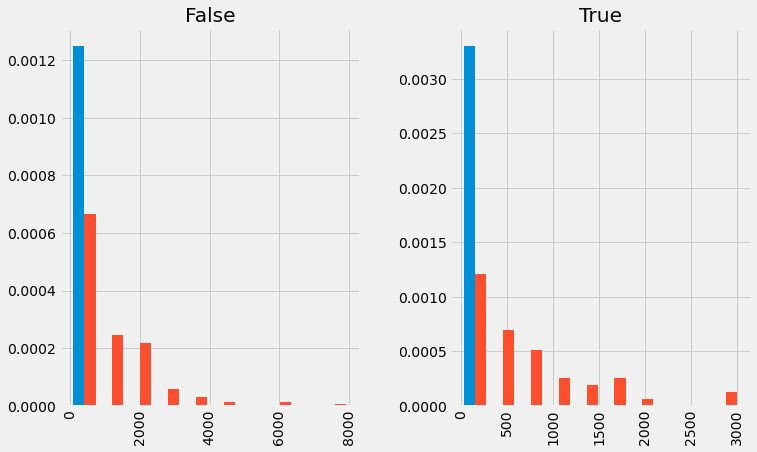

In [13]:
isNull = itsChurn.song!='null'
get_Song = itsChurn.where(isNull)
cSong = get_Song.groupby(['churn','userId'])
songs = count(itsChurn.song)
songs = songs.alias('SongsPlayed')
SongAgr = cSong.agg(songs)
SongOr = SongAgr.orderBy('churn').toPandas()
dims = (12, 7)
fig, ax = plt.subplots(figsize=dims)
plt.style.use('fivethirtyeight') 
SongOr.hist(['SongsPlayed'], ax=ax, by='churn',density=5)
plt.plot()

D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:412: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

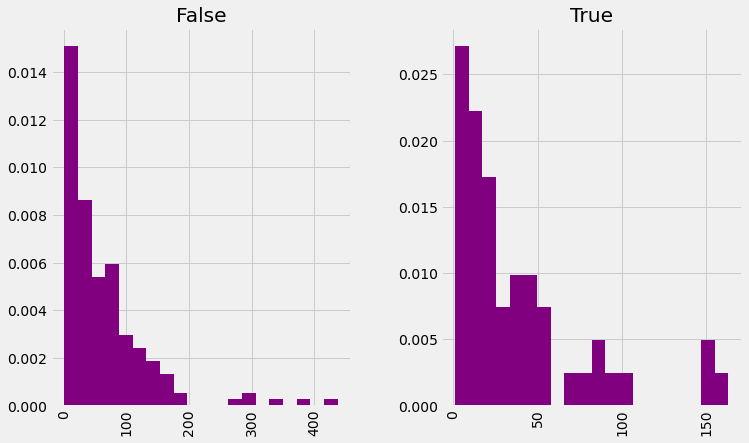

In [14]:
# the average of ThumpsUp group and ThumpsDown group
checkThumbsUp = itsChurn.page =='Thumbs Up'
counColUp = count(col('page'))
counColUp = counColUp.alias('ThumbsUps')
thumbsUpCh = itsChurn.where(checkThumbsUp)
thumbsUpGroup = thumbsUpCh.groupby(['churn','userId'])
thumbsUpAgr = thumbsUpGroup.agg(counColUp)
thumbsUpChurn = thumbsUpAgr.orderBy('churn')
thumbsUp = thumbsUpChurn.toPandas()
dims = (12, 7)
fig, ax = plt.subplots(figsize=dims)
plt.style.use('fivethirtyeight') 
thumbsUp.hist('ThumbsUps', by='churn', color = "purple", bins=20, ax=ax, density=5)

<AxesSubplot:>

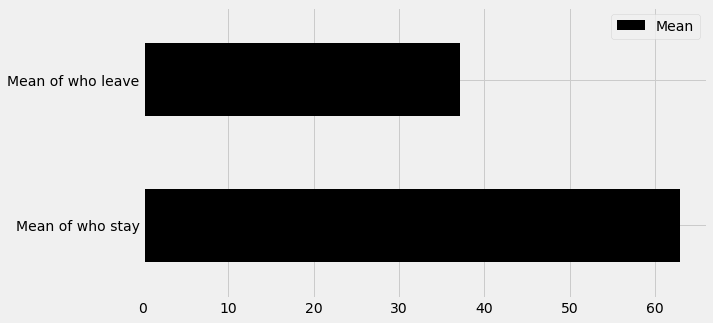

In [15]:
# the mean of ThumbsUp for who stay and the mean of ThumbsUp for who leave
checkStayUp = thumbsUp['churn']==False
checkLeaveUp = thumbsUp['churn']==True
stayUp = thumbsUp[checkStayUp]['ThumbsUps']
leaveUp = thumbsUp[checkLeaveUp]['ThumbsUps']
stayMeanUp = stayUp.mean()
leaveMeanUp = leaveUp.mean()
dims = (9, 5)
fig, ax = plt.subplots(figsize=dims)
plt.style.use('fivethirtyeight') 
sparkDf = pd.DataFrame({'': ["Mean of who stay", "Mean of who leave"], 'Mean': [stayMeanUp, leaveMeanUp]})
sparkDf.plot.barh(x='', y='Mean', color='black', ax=ax)

<AxesSubplot:>

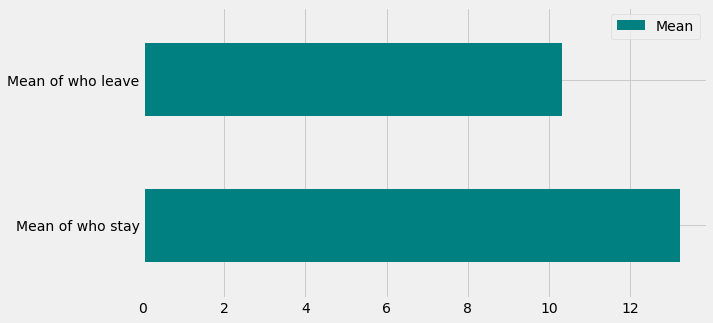

In [16]:
# the mean of ThumbsDown for who stay and the mean of ThumbsDown for who leave
checkThumbsDown = itsChurn.page=='Thumbs Down'
thumbsDown = itsChurn.where(checkThumbsDown)
thumbsDown = thumbsDown.groupby(['churn','userId'])
counColDown = count(col('page'))
counColDown = counColDown.alias('ThumbsDowns')
thumbsDown = thumbsDown.agg(counColDown)
thumbsDown = thumbsDown.orderBy('churn')
thumbsDown = thumbsDown.toPandas()

checkStayDown = thumbsDown['churn']==False
checkLeaveDown = thumbsDown['churn']==True
stayDown = thumbsDown[checkStayDown]['ThumbsDowns']
leaveDown = thumbsDown[checkLeaveDown]['ThumbsDowns']
stayMeanDown = stayDown.mean()
leaveMeanDown = leaveDown.mean()
dims = (9, 5)
fig, ax = plt.subplots(figsize=dims)
plt.style.use('fivethirtyeight') 
sparkDf = pd.DataFrame({'': ["Mean of who stay", "Mean of who leave"], 'Mean': [stayMeanDown, leaveMeanDown]})
sparkDf.plot.barh(x='', y='Mean', color='teal', ax=ax)

In [17]:
dateDay = lambda x: datetime.datetime.fromtimestamp(x/1000)
NextSong = lambda x : int(x=='NextSong')
checkChurn1 = col('churn')==1
checkChurn0 = col('churn')==0
date = udf(dateDay, DateType())
song = udf(NextSong, IntegerType())
songCol = song(col('page'))
ts = date(col('ts'))
itsChurn = itsChurn.withColumn('date', ts)
churn = itsChurn.filter(checkChurn1)
churn = churn.withColumn('songPlayed', songCol)
notChurn = itsChurn.filter(checkChurn0)
notChurn = notChurn.withColumn('songPlayed', songCol)

In [18]:
# the number of songs that played from churned users and not churned users
countChurn = churn.agg({'songPlayed':'count'})
countNotChurn = notChurn.agg({'songPlayed':'count'})
countChurn.show()
countNotChurn.show()

+-----------------+
|count(songPlayed)|
+-----------------+
|            44864|
+-----------------+

+-----------------+
|count(songPlayed)|
+-----------------+
|           233290|
+-----------------+



In [19]:
# the mean of songs that played from churned users and not churned users
meanChurn = churn.agg({'songPlayed':'mean'})
meanNotChurn = notChurn.agg({'songPlayed':'mean'})
meanChurn.show()
meanNotChurn.show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [20]:
# the number of songs that are not played because of an error occurred ( churn )
isError = itsChurn.page =='Error'
isChurn = itsChurn.churn == 1
cFiltPlayed = itsChurn.filter(isError & isChurn)
cSelPlayed = cFiltPlayed.select('userId', 'page', 'ts', 'length')
cChurnTs = cSelPlayed.withColumn('date', ts)
cPlayedGroup = cChurnTs.groupBy('userId', 'date')
cPlayedAgr = cPlayedGroup.agg({'page':'count'})
cSelPlayed = cPlayedAgr.select('count(page)')
churnPlayed = cSelPlayed.describe()

churnPlayed.show()

+-------+------------------+
|summary|       count(page)|
+-------+------------------+
|  count|                31|
|   mean| 1.032258064516129|
| stddev|0.1796053020267749|
|    min|                 1|
|    max|                 2|
+-------+------------------+



In [21]:
# the number of songs that are not played because of an error occurred ( not churn )
isNotChurn = itsChurn.churn == 0
nFiltPlayed = itsChurn.filter(isError & isNotChurn )
nSelPlayed = nFiltPlayed.select('userId', 'page', 'ts', 'length')
nChurnTs = nSelPlayed.withColumn('date', date(col('ts')))
nPlayedGroup = nChurnTs.groupBy('userId', 'date')
nPlayedAgr = nPlayedGroup.agg({'page':'count'})
nSelPlayed = nPlayedAgr.select('count(page)')
notChurnPlayed = nSelPlayed.describe()

notChurnPlayed.show()

+-------+------------------+
|summary|       count(page)|
+-------+------------------+
|  count|               199|
|   mean|1.1055276381909547|
| stddev| 0.323989646283549|
|    min|                 1|
|    max|                 3|
+-------+------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
# replace gender from (M , F) to (1 , 0)
dupGender = itsChurn.dropDuplicates(['userId'])
sGender = dupGender.sort('userId')
selGender = sGender.select(['userId','gender'])
gender = selGender.replace(['F','M'], ['1', '0'], 'gender')

In [23]:
# overview
castGender = gender.gender.cast("int")
gender.withColumn('gender', castGender)
gender.describe().show()
gender.show()

+-------+------------------+------------------+
|summary|            userId|            gender|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.4622222222222222|
| stddev|105396.47791907164|0.4996824388374477|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



In [24]:
# the total number of days beginning from registration day 
userDaygr = itsChurn.groupby("userId")
userDaymax = userDaygr.max("ts")
sUserDay = userDaymax.sort("userId")
selUserDay = itsChurn.select("userId", "registration")
dupuUserDay = selUserDay.dropDuplicates()
sDupuUserDay = dupuUserDay.sort("userId")
day = sDupuUserDay.userId == sUserDay.userId
userDays = sDupuUserDay.join(sUserDay, day)
sub = sUserDay["max(ts)"] - sDupuUserDay["registration"]
registration = sub/(1000*60*60*24)
registrationDays = registration.alias("registrationDays")
getUser = sDupuUserDay["userId"]
userRegistration = userDays.select(getUser, registrationDays)

userRegistration.show()

+------+------------------+
|userId|  registrationDays|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|        53.9659375|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [25]:
# the total number of song that was played
isSong = itsChurn.song != 'null'
countSong = count(itsChurn.song)
songsPlayed = countSong.alias('SongsPlayed')
songsPlayedD = itsChurn.where(isSong)
songsPlayedGr = songsPlayedD.groupby('userId')
songsPlayedAgr = songsPlayedGr.agg(songsPlayed)
songsPlayedOrd = songsPlayedAgr.orderBy('userId')
selSongsPlayed = songsPlayedOrd.select(['userId','SongsPlayed'])

selSongsPlayed.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [26]:
# the total number of song for each session
nextSong = itsChurn.page == "NextSong"
songSession = itsChurn.filter(nextSong)
songSessionGro = songSession.groupby("userId", "sessionId")
songSessionCount = songSessionGro.count()
sessionSongsGro = songSessionCount.groupby("userId")
avgs = avg(songSessionCount["count"])
avgSessionSongs = avgs.alias("avgSessionSongs")
sessionSongsAgr = sessionSongsGro.agg(avgSessionSongs)
sSessionSongs = sessionSongsAgr.sort("userId")

sSessionSongs.show()

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
|100004|              47.1|
|100005|              38.5|
|100006|              26.0|
|100007|              47.0|
|100008|128.66666666666666|
|100009|              51.8|
|100010|39.285714285714285|
|100011|              11.0|
|100012| 79.33333333333333|
|100013|              87.0|
|100014|42.833333333333336|
|100015| 66.66666666666667|
|100016|             66.25|
|100017|              52.0|
|100018|              50.1|
+------+------------------+
only showing top 20 rows



In [27]:
# the total number of session for each user
userS = itsChurn.select("userId", "sessionId")
userSDup = userS.dropDuplicates()
userSGro = userSDup.groupby("userId")
countUserS = userSGro.count()
renamedSession = countUserS.withColumnRenamed("count", "sessionCount")
userSession = renamedSession.sort('userID')

userSession.describe().show()
userSession.show()

+-------+------------------+------------------+
|summary|            userId|      sessionCount|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|14.115555555555556|
| stddev|105396.47791907164| 14.64688465711156|
|    min|                10|                 1|
|    max|                99|               107|
+-------+------------------+------------------+

+------+------------+
|userId|sessionCount|
+------+------------+
|    10|           6|
|   100|          35|
|100001|           4|
|100002|           4|
|100003|           2|
|100004|          21|
|100005|           5|
|100006|           1|
|100007|           9|
|100008|           6|
|100009|          10|
|100010|           7|
|100011|           1|
|100012|           7|
|100013|          14|
|100014|           6|
|100015|          12|
|100016|           8|
|100017|           1|
|100018|          21|
+------+------------+
only showing top 20 rows



In [28]:
# the average time that taken for each session
sessionTime = itsChurn.groupby("userId", "sessionId")
maxTs = max(itsChurn.ts)
minTs = min(itsChurn.ts)
diff = maxTs - minTs
session = diff/(1000*60)
session = session.alias("sessionTime")
sessionTimeAgr = sessionTime.agg(session)
sessionTimeGro = sessionTimeAgr.groupby("userId")
avg = avg(sessionTimeAgr.sessionTime)
avgSession = avg.alias("avgSessionTime")
avgSessionTimeAgr = sessionTimeGro.agg(avgSession)
sAvgSessionTime = avgSessionTimeAgr.sort("userId")

sAvgSessionTime.describe().show()
sAvgSessionTime.show()

+-------+------------------+------------------+
|summary|            userId|    avgSessionTime|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336| 288.1659840733498|
| stddev|105396.47791907164|176.84244472357116|
|    min|                10|               7.0|
|    max|                99|            1179.9|
+-------+------------------+------------------+

+------+------------------+
|userId|    avgSessionTime|
+------+------------------+
|    10|459.74722222222226|
|   100| 316.5190476190476|
|100001|148.15833333333333|
|100002|201.18333333333334|
|100003| 99.11666666666667|
|100004|185.98650793650793|
|100005|120.18666666666668|
|100006| 93.43333333333334|
|100007|189.41111111111113|
|100008| 528.2527777777779|
|100009|211.96166666666667|
|100010|154.48333333333332|
|100011| 44.38333333333333|
|100012|271.43809523809523|
|100013|329.99880952380954|
|100014| 184.8138888888889|
|100015|278.59444444444443|
|100016

In [29]:
# the number of singer that the user was listened
singer = itsChurn.dropDuplicates(['userId','artist'])
singerGro = singer.groupby('userId')
nbArtist = count(itsChurn.artist)
SingersListened = nbArtist.alias('SingersListened')
singerAgr = singerGro.agg(SingersListened).orderBy('userId')
singerAgr.select(['userId','SingersListened'])

singerAgr.describe().show()
singerAgr.show()

+-------+------------------+-----------------+
|summary|            userId|  SingersListened|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630803|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
|100009|            442|
|100010|            252|
|100011|             11|
|100012|            397|
|100013|            826|
|100014|            233|
|100015|            627|
|100016|            431|
|100017|             51|
|100018|            780|
+

In [30]:
# the total Number of friends for each user
isFriend = itsChurn.page=='Add Friend'
userFriend = itsChurn.filter(isFriend)
selUserFriend = userFriend.select('userId', 'page')
userFriendGro = selUserFriend.groupBy('userId')
countUserFriend = userFriendGro.count()
renamedCountFriend = countUserFriend.withColumnRenamed('count', 'numFriends')
friends = renamedCountFriend.sort('userId')

friends.describe().show()
friends.show()

+-------+------------------+------------------+
|summary|            userId|        numFriends|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425009| 20.64677907440501|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+

+------+----------+
|userId|numFriends|
+------+----------+
|    10|        12|
|   100|        49|
|100001|         2|
|100002|         1|
|100004|        19|
|100005|         3|
|100006|         4|
|100007|        17|
|100008|        17|
|100009|         7|
|100010|         4|
|100012|         2|
|100013|        28|
|100014|         6|
|100015|        14|
|100016|        13|
|100018|        23|
|100019|         2|
|100021|         7|
|100022|        11|
+------+----------+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

<AxesSubplot:xlabel='churn', ylabel='count'>

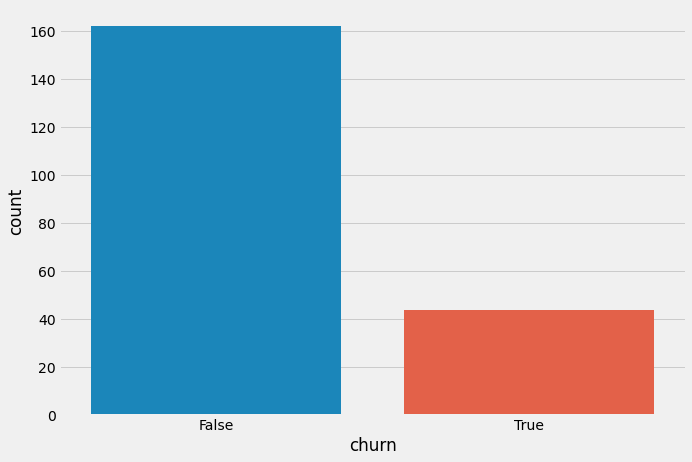

In [31]:
# the total number of churn and not churn
users = itsChurn.dropDuplicates(['userId'])
sUsers = users.sort('userId')
selUsers = sUsers.select(['userId','churn'])

for x in [gender, userRegistration, selSongsPlayed, sAvgSessionTime, singerAgr, sSessionSongs, userSession, friends]:
    selUsers = selUsers.join(x,'userId')
    
usersGro = selUsers.groupby("churn")
countUsers = usersGro.count()
userz = countUsers.toPandas()
dims = (10, 7)
fig, ax = plt.subplots(figsize=dims)
plt.style.use('fivethirtyeight') 
sns.barplot(x="churn", y="count", ax=ax, data=userz)

In [32]:
# data types
selUsers.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('gender', 'string'),
 ('registrationDays', 'double'),
 ('SongsPlayed', 'bigint'),
 ('avgSessionTime', 'double'),
 ('SingersListened', 'bigint'),
 ('avgSessionSongs', 'double'),
 ('sessionCount', 'bigint'),
 ('numFriends', 'bigint')]

In [33]:
# general details
selUsers.describe()

DataFrame[summary: string, userId: string, gender: string, registrationDays: string, SongsPlayed: string, avgSessionTime: string, SingersListened: string, avgSessionSongs: string, sessionCount: string, numFriends: string]

In [34]:
# show the data
selUsers.show(5)

+------+-----+------+------------------+-----------+------------------+---------------+------------------+------------+----------+
|userId|churn|gender|  registrationDays|SongsPlayed|    avgSessionTime|SingersListened|   avgSessionSongs|sessionCount|numFriends|
+------+-----+------+------------------+-----------+------------------+---------------+------------------+------------+----------+
|    10|false|     0| 51.76265046296297|        673|459.74722222222226|            565|112.16666666666667|           6|        12|
|   100|false|     0| 64.87377314814815|       2682| 316.5190476190476|           1705| 78.88235294117646|          35|        49|
|100001| true|     1| 44.80021990740741|        133|148.15833333333333|            125|             33.25|           4|         2|
|100002|false|     1|160.47207175925925|        195|201.18333333333334|            184|             48.75|           4|         1|
|100004|false|     1|172.44008101851853|        942|185.98650793650793|            

In [35]:
features = selUsers.columns[1:]
for x in features:
    name = x + "Num"
    selUsers = selUsers.withColumn(name, selUsers[x].cast("float"))
    selUsers = selUsers.drop(x)

In [36]:
# transforming, selecting features and scale
cols = selUsers.columns[2:]
VA = VectorAssembler(inputCols = cols, outputCol="NumFeatures")
resultsDF = VA.transform(selUsers)
SS = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
sModel = SS.fit(resultsDF)
results = sModel.transform(resultsDF)
label = results.churnNum.alias("label")
features = results.ScaledNumFeatures.alias("features")
results = results.select(label, features)

In [37]:
# split data randomlay then use sampleBy to returns stratified sample without replacement by the fraction
fraction = {0: 99/349, 1: 1.0}
rang = [0.9, 0.1]
train, validation = results.randomSplit(rang, seed=42)
train = train.cache()
sTrain = train.sampleBy('label', fractions=fraction)
sTrain = sTrain.cache()

In [38]:
# create LogisticRegression model and build ParamGrid then use cross validation
log_model =  LogisticRegression()
param = ParamGridBuilder()
addGrid = param.addGrid(log_model.elasticNetParam,[0.0, 0.1, 0.5, 1.0])
builder = addGrid.addGrid(log_model.regParam,[0.0, 0.05, 0.1])
builder = builder.build()
cValidation = CrossValidator(estimator = log_model, estimatorParamMaps = builder, 
                          evaluator= MulticlassClassificationEvaluator(), numFolds = 3)
log_model = cValidation.fit(sTrain)

log_model.bestModel

LogisticRegressionModel: uid=LogisticRegression_7fdc81d10916, numClasses=2, numFeatures=8

In [39]:
# the results by using Accuracy, Precision, Recall, and F1-score
trans = log_model.transform(validation)
truePositive = trans.filter("label = 1 and prediction = 1")
truePositive = truePositive.count()
falsePositive = trans.filter("label = 0 and prediction = 1")
falsePositive = falsePositive.count()
falseNegative = trans.filter("label = 1 and prediction = 0")
falseNegative = falseNegative.count()
trueNegative = trans.filter("label = 0 and prediction = 0")
trueNegative = trueNegative.count()

precision = truePositive / (truePositive + falseNegative) 
print("Precision:", precision)

recall = truePositive / (truePositive + falseNegative)
print("Recall:", recall)

accuracy = (truePositive + trueNegative) / (truePositive + falsePositive + trueNegative + falseNegative)
print("Accuracy:", accuracy)

f1_score = 2*precision*recall / ( precision + recall)
print("F1-score:", f1_score)

Precision: 0.5
Recall: 0.5
Accuracy: 0.7142857142857143
F1-score: 0.5


In [40]:
# create Decision Tree model and build ParamGrid then use cross validation
dTree = DecisionTreeClassifier()
param = ParamGridBuilder()
addGrid = param.addGrid(dTree.impurity,['entropy', 'gini'])
builder = addGrid.addGrid(dTree.maxDepth,[2, 3, 4, 5, 6, 7, 8])
builder = builder.build()
cValidation = CrossValidator(estimator = dTree, estimatorParamMaps = builder,
                          evaluator = MulticlassClassificationEvaluator(), numFolds = 3)
dTree_model = cValidation.fit(train)

dTree_model.bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_9587b1d635fa, depth=2, numNodes=5, numClasses=2, numFeatures=8

In [41]:
# the results by using Accuracy, Precision, Recall, and F1-score
trans = log_model.transform(validation)
truePositive = trans.filter("label = 1 and prediction = 1")
truePositive = truePositive.count()
falsePositive = trans.filter("label = 0 and prediction = 1")
falsePositive = falsePositive.count()
falseNegative = trans.filter("label = 1 and prediction = 0")
falseNegative = falseNegative.count()
trueNegative = trans.filter("label = 0 and prediction = 0")
trueNegative = trueNegative.count()

precision = truePositive / (truePositive + falseNegative) 
print("Precision:", precision)

recall = truePositive / (truePositive + falseNegative)
print("Recall:", recall)

accuracy = (truePositive + trueNegative) / (truePositive + falsePositive + trueNegative + falseNegative)
print("Accuracy:", accuracy)

f1_score = 2*precision*recall / ( precision + recall)
print("F1-score:", f1_score)

Precision: 0.5
Recall: 0.5
Accuracy: 0.7142857142857143
F1-score: 0.5


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.